
   ###  2D Stochastic Gaussian Simulation in Python for Engineers and Geoscientists 

### with GSLIB's IK3D Program Converted to Python

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 


#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

This is the test of the IK3D GSLIB (Deutsch and Journel, 1997) reimplimented in Python (Michael Pyrcz). It will be added shortly to GeostatsPy.


### Explanation of GeostatsPy

GeostatsPy includes functions that run 2D workflows in GSLIB from Python (i.e. low tech wrappers), Python translations and in some cases reimplementations of GSLIB methods, along with utilities to move between GSLIB's Geo-EAS data sets and Pandas DataFrames, and grids and 2D NumPy ndarrays respectively and other useful operations such as resampling from regular datasets and rescaling distributions.  

The reimplementations as of now include NSCORE, GAM, GAMV, DECLUS and most of the visualizations using the standard GSLIB parametric inputs and matplotlib back end. The low tech wrappers simply write the GSLIB parameters, run the GSLIB executables and then read in the GSLIB output. This allows for construction of Python workflows with the very robust GSLIB programs.

#### Why make this package? 

I wanted a set of functions for working with the very robust and numerically efficient GSLIB: Geostatistical Library (Deutsch and Journel, 1998) in Python.  While there are other current solutions in Python.  I found that these solutions are either proprietary (not open source), not maintained or missing vital functionality; therefore, I have not been able to use these other solutions to teach modeling workflows to students with little or no programming experience.  Imagine getting 55 undergraduate students to role back to a previous version on Python because a single dependency of an available package is not available in a current Python version.  Image a student about to submit an assignment, and the code won't run immediately before submission because of an update to a dependency. I need methods for my students that just work, are reliable and do not require students to complete a more complicated environment setup.


#### Load the required libraries

The following code loads the required libraries.

In [1]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting

import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [331]:
os.chdir("C:/Users/mpyrc/OneDrive - The University of Texas at Austin/Courses/PGE383_Spring2019/Example")

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  For fun try misspelling the name. You will get an ugly, long error. 

In [332]:
df = pd.read_csv('12_sample_data.csv')     # load our data table (wrong name!)

We loaded our file into our DataFrame called 'df'. But how do you really know that it worked? Visualizing the DataFrame would be useful and we already leard about these methods in this demo (https://git.io/fNgRW). 

We can preview the DataFrame by printing a slice or by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the slice we could look at any subset of the data table and with the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [334]:
df.head(n=13)                           # we could also use this command for a table preview

,X,Y,Facies,Porosity,Perm,AI
0,50,900,1,0.220761,140.021266,3413.063944
1,50,850,1,0.237154,39.837129,3074.562617
2,50,800,1,0.234352,84.992437,2292.783358
3,50,750,1,0.244553,90.632307,2494.848885
4,50,700,1,0.231787,811.547979,2522.063995
5,50,650,1,0.233280,426.992456,3964.185956
6,50,550,1,0.234423,2398.406492,3318.885844
7,50,500,1,0.219657,1637.224971,3030.874323
8,50,450,1,0.200389,265.636019,3454.389302
9,50,350,0,0.165908,7.951511,5025.286221


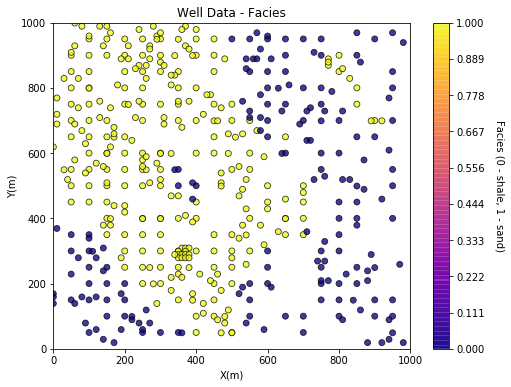

In [359]:
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values

xsiz = 10; ysiz = 10
nx = 100; ny = 100
xmn = 5; ymn = 5

cmap = plt.cm.plasma                    # color map
GSLIB.locmap(df,'X','Y','Facies',xmin,xmax,ymin,ymax,0,1,'Well Data - Facies','X(m)','Y(m)','Facies (0 - shale, 1 - sand)',cmap,'locmap_facies')

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

These are some of the functions from GeostatsPy required by the new program.  We will declare them here and then in the future integrate the new indicator kriging program into the package properly.

In [335]:
def setup_rotmat(c0, nst, it, cc, ang, pmx):

    PI = 3.141_592_65
    DTOR = PI / 180.0

    # The first time around, re-initialize the cosine matrix for the variogram
    # structures
    rotmat = np.zeros((4, nst))
    maxcov = c0
    for js in range(0, nst):
        azmuth = (90.0 - ang[js]) * DTOR
        rotmat[0, js] = math.cos(azmuth)
        rotmat[1, js] = math.sin(azmuth)
        rotmat[2, js] = -1 * math.sin(azmuth)
        rotmat[3, js] = math.cos(azmuth)
        if it[js] == 4:
            maxcov = maxcov + pmx
        else:
            maxcov = maxcov + cc[js]
    return rotmat, maxcov

def ksol_numpy(neq, a, r):
    a = a[0: neq * neq]  # trim the array
    a = np.reshape(a, (neq, neq))  # reshape to 2D
    ainv = linalg.inv(a)  # invert matrix
    r = r[0: neq]  # trim the array
    s = np.matmul(ainv, r)  # matrix multiplication
    return s

def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    EPSLON = 0.000_000
    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1
    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
#        print('cova h'); print(h)
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
            cov1 = pmx - cc[js] * (h ** aa[js])
            cova2_ = cova2_ + cov1
    return cova2_

Here is the new indicator kriging program along with a couple of supporting functions.

In [426]:
import scipy.spatial as sp         # for fast nearest nearbour search
import math  # for trig functions etc.
import numpy.linalg as linalg  # for linear algebra

def correct_trend(trend):
    ny = trend.shape[0]
    nx = trend.shape[1]
    ncut = trend.shape[2]
    for iy in range(0,ny):
        for ix in range(0,nx):
            sum = 0.0
            for ic in range(0,ncut):
                sum = sum + trend[iy,ix,ic]
            if sum > 0.0:
                for icut in range(0,ncut):
                    trend[iy,ix,ic] = trend[iy,ix,ic] / sum
    return trend

def ordrel(ivtype,ncut,ccdf):
#    print('input ordering relations'); print(ccdf)
    ccdfo = np.zeros(ncut)
    ccdf1 = np.zeros(ncut)
    ccdf2 = np.zeros(ncut) # do we need MAXCUT = 100 for these 2?

# Make sure conditional cdf is within [0,1]:
    for i in range(0,ncut):
        if ccdf[i] < 0.0:
            ccdf1[i] = 0.0
            ccdf2[i] = 0.0
        elif ccdf[i] > 1.0:
            ccdf1[i] = 1.0
            ccdf2[i] = 1.0
        else:
            ccdf1[i] = ccdf[i]
            ccdf2[i] = ccdf[i]
#    print('ordering relations'); print(ccdf1,ccdf2)

# Correct sequentially up, then down, and then average:
    if ivtype == 0:
        sumcdf = 0.0
        for i in range(0,ncut):
            sumcdf = sumcdf + ccdf1[i]
        if sumcdf <= 0.0: sumcdf = 1.0
        for i in range(0,ncut):
            ccdfo[i] = ccdf1[i] / sumcdf
    else:
        for i in range(1,ncut):
            if ccdf1[i] < ccdf1[i-1]: ccdf1[i] = ccdf1[i-1]
        for i in range(ncut-2,0,-1):
            if ccdf2[i] > ccdf2[i+1]: ccdf2[i] = ccdf2[i+1]
        for i in range(0,ncut):
            ccdfo[i] = 0.5*(ccdf1[i]+ccdf2[i])

# Return with corrected CDF:
    return ccdfo


def ik2d(df,xcol,ycol,vcol,ivtype,koption,ncut,thresh,gcdf,trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,
         ndmin,ndmax,radius,ktype,vario): 

# Find the needed paramters:
    PMX = 9999.9
    MAXSAM = ndmax + 1
    MAXEQ = MAXSAM + 1
    mik = 0  # full indicator kriging
    use_trend = False
    if trend.shape[0] == nx and trend.shape[1] == ny and trend.shape[2] == ncut: use_trend = True
    
# load the variogram
    MAXNST = 2
    nst = np.zeros(ncut,dtype=int); c0 = np.zeros(ncut); cc = np.zeros((MAXNST,ncut)) 
    aa = np.zeros((MAXNST,ncut),dtype=int); it = np.zeros((MAXNST,ncut),dtype=int) 
    ang = np.zeros((MAXNST,ncut)); anis = np.zeros((MAXNST,ncut))

    for icut in range(0,ncut):
        nst[icut] = int(vario[icut]['nst'])
        c0[icut] = vario[icut]['nug']; cc[0,icut] = vario[icut]['cc1']; it[0,icut] = vario[icut]['it1']; 
        ang[0,icut] = vario[icut]['azi1']; 
        aa[0,icut] = vario[icut]['hmaj1']; anis[0,icut] = vario[icut]['hmin1']/vario[icut]['hmaj1'];
        if nst[icut] == 2:
            cc[1,icut] = vario[icut]['cc2']; it[1,icut] = vario[icut]['it2']; ang[1,icut] = vario[icut]['azi2']; 
            aa[1,icut] = vario[icut]['hmaj2']; anis[1,icut] = vario[icut]['hmin2']/vario[icut]['hmaj2'];

# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    MAXDAT = len(df_extract)
    MAXCUT = ncut
    MAXNST = 2
    MAXROT = MAXNST*MAXCUT+ 1
    ikout = np.zeros((nx,ny,ncut))
    maxcov = np.zeros(ncut)
            
    # Allocate the needed memory:   
    xa = np.zeros(MAXSAM)
    ya = np.zeros(MAXSAM)
    vra = np.zeros(MAXSAM)
    dist = np.zeros(MAXSAM)
    nums = np.zeros(MAXSAM)
    r = np.zeros(MAXEQ)
    rr = np.zeros(MAXEQ)
    s = np.zeros(MAXEQ)
    a = np.zeros(MAXEQ*MAXEQ)
    ikmap = np.zeros((nx,ny,ncut))
    vr = np.zeros((MAXDAT,MAXCUT+1))
    
    nviol = np.zeros(MAXCUT)
    aviol = np.zeros(MAXCUT)
    xviol = np.zeros(MAXCUT)
    
    ccdf = np.zeros(ncut)
    ccdfo = np.zeros(ncut)
    ikout = np.zeros((nx,ny,ncut))
    
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    v = df_extract[vcol].values
    
# The indicator data are constructed knowing the thresholds and the
# data value.
    
    if ivtype == 0:
        for icut in range(0,ncut): 
            vr[:,icut] = np.where((v <= thresh[icut] + 0.5) & (v > thresh[icut] - 0.5), '1', '0')
    else:
        for icut in range(0,ncut): 
            vr[:,icut] = np.where(v <= thresh[icut], '1', '0')
    vr[:,ncut] = v

# Make a KDTree for fast search of nearest neighbours   
    dp = list((y[i], x[i]) for i in range(0,MAXDAT))
    data_locs = np.column_stack((y,x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
    
# Summary statistics of the input data
    
    avg = vr[:,ncut].mean()
    stdev = vr[:,ncut].std()
    ss = stdev**2.0
    vrmin = vr[:,ncut].min()
    vrmax = vr[:,ncut].max()
    print('Data for IK3D: Variable column ' + str(vcol))
    print('  Number   = ' + str(MAXDAT))
    ndh = MAXDAT
    
    actloc = np.zeros(MAXDAT, dtype = int)
    for i in range(1,MAXDAT):
        actloc[i] = i
    
# Set up the rotation/anisotropy matrices that are needed for the
# variogram and search:

    print('Setting up rotation matrices for variogram and search')
    radsqd = radius * radius
    rotmat = []
    for ic in range(0,ncut):  
        rotmat_temp, maxcov[ic] = setup_rotmat(c0[ic],int(nst[ic]),it[:,ic],cc[:,ic],ang[:,ic],9999.9)
        rotmat.append(rotmat_temp)    
# Initialize accumulators:  # not setup yet
    nk = 0
    xk = 0.0
    vk = 0.0
    for icut in range (0,ncut):
        nviol[icut] =  0
        aviol[icut] =  0.0
        xviol[icut] = -1.0
    nxy   = nx*ny
    print('Working on the kriging')

# Report on progress from time to time:
    if koption == 0: 
        nxy   = nx*ny
        nloop = nxy
        irepo = max(1,min((nxy/10),10000))
    else:
        nloop = 10000000
        irepo = max(1,min((nd/10),10000))
    ddh = 0.0
    
# MAIN LOOP OVER ALL THE BLOCKS IN THE GRID:
    for index in range(0,nloop):
      
        if (int(index/irepo)*irepo) == index: print('   currently on estimate ' + str(index))
    
        if koption == 0:
            iy   = int((index)/nx) 
            ix   = index - (iy)*nx
            xloc = xmn + (ix)*xsiz
            yloc = ymn + (iy)*ysiz
        else:
            ddh = 0.0
            # TODO: pass the cross validation value

# Find the nearest samples within each octant: First initialize the counter arrays:
        na = -1   # accounting for 0 as first index
        dist.fill(1.0e+20)
        nums.fill(-1)
        current_node = (yloc,xloc)
        dist, close = tree.query(current_node,ndmax) # use kd tree for fast nearest data search
        # remove any data outside search radius
        close = close[dist<radius]
        dist = dist[dist<radius] 
        nclose = len(dist) 

# Is there enough samples?

        if nclose < ndmin:   # accounting for min index of 0
            for i in range(0,ncut):
                ccdfo[i] = UNEST
            print('UNEST at ' + str(ix) + ',' + str(iy))
        else:         

# Loop over all the thresholds/categories:
            for ic in range(0,ncut):
                krig = True
                if mik == 1 and ic >= 1: krig = False

# Identify the close data (there may be a different number of data at
# each threshold because of constraint intervals); however, if
# there are no constraint intervals then this step can be avoided.
                nca = -1
                for ia in range(0,nclose):
                    j  = int(close[ia]+0.5)
                    ii = actloc[j]
                    accept = True
                    if koption != 0 and (abs(x[j]-xloc) + abs(y[j]-yloc)).lt.EPSLON: accept = False
                    if accept:
                        nca = nca + 1
                        vra[nca] = vr[ii,ic]
                        xa[nca]  = x[j]
                        ya[nca]  = y[j]

# If there are no samples at this threshold then use the global cdf:
                if nca == -1:
                    if use_trend:
                        ccdf[ic] = trend[ny-iy-1,ix,ic]
                    else:
                        ccdf[ic] = gcdf[ic]
                else:
            
# Now, only load the variogram, build the matrix,... if kriging:
                    neq = nclose + ktype
                    na = nclose

# Set up kriging matrices:
                    iin=-1 # accounting for first index of 0
                    for j in range(0,na):
# Establish Left Hand Side Covariance Matrix:
                        for i in range(0,na):  # was j - want full matrix                    
                            iin = iin + 1
                            a[iin] = cova2(xa[i],ya[i],xa[j],ya[j],nst[ic],c0[ic],PMX,cc[:,ic],aa[:,ic],it[:,ic],ang[:,ic],anis[:,ic],rotmat[ic],maxcov[ic]) 
                        if ktype == 1:
                            iin = iin + 1
                            a[iin] = maxcov[ic]            
                        r[j] = cova2(xloc,yloc,xa[j],ya[j],nst[ic],c0[ic],PMX,cc[:,ic],aa[:,ic],it[:,ic],ang[:,ic],anis[:,ic],rotmat[ic],maxcov[ic]) 
    
# Set the unbiasedness constraint:
                    if ktype == 1:
                        for i in range(0,na):
                            iin = iin + 1
                            a[iin] = maxcov[ic]
                        iin      = iin + 1
                        a[iin]   = 0.0
                        r[neq-1]  = maxcov[ic]
                        rr[neq-1] = r[neq]
# Solve the system:
                    if neq == 1:
                        ising = 0.0
                        s[0]  = r[0] / a[0]
                    else:
                        s = ksol_numpy(neq,a,r)

# Finished kriging (if it was necessary):

# Compute Kriged estimate of cumulative probability:
                    sumwts   = 0.0
                    ccdf[ic] = 0.0
                    for i in range(0,nclose):
                        ccdf[ic] = ccdf[ic] + vra[i]*s[i]
                        sumwts   = sumwts   + s[i]
                    if ktype == 0: 
                        if use_trend == True:
                            ccdf[ic] = ccdf[ic] + (1.0-sumwts)*trend[ny-iy-1,ix,ic]
                        else:
                            ccdf[ic] = ccdf[ic] + (1.0-sumwts)*gcdf[ic]

# Keep looping until all the thresholds are estimated:
 
# Correct and write the distribution to the output file:
            nk = nk + 1
            ccdfo = ordrel(ivtype,ncut,ccdf)
        
# Write the IK CCDF for this grid node:
            if koption == 0:
                 ikout[ny-iy-1,ix,:] = ccdfo
            else:
                 print('TBD')
    return ikout  


For this example lets just assume the indicator variograms for the 2 facies, 0 is shale and 1 is sand.  We declare a list and then add the variograms in the order of the categories in the thresh and global cdf arrays.

In [427]:
ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories
gcdf = [0.4,0.6]                           # the global proportions of the categories
varios = []                                # the variogram list
varios.append(make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=50,hmin1=40)) # shale indicator variogram
varios.append(make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=50,hmin1=40)) # sand indicator variogram

Now let's just specify the other kriging parameters.

In [428]:
nxdis = 1; nydis = 1                       # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 10                      # minimum and maximum data for kriging 
radius = 100                                # maximum search distance
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
ivtype = 0                                 # variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 999;                   # data trimming limits

Let's make a very simple trend model just based on the x coordinate and correct the trend to sum to one.  See I'm only modifying the shale proportion and using the correction to adjust the sand.  This is quite ad hoc and just for demonstration. 

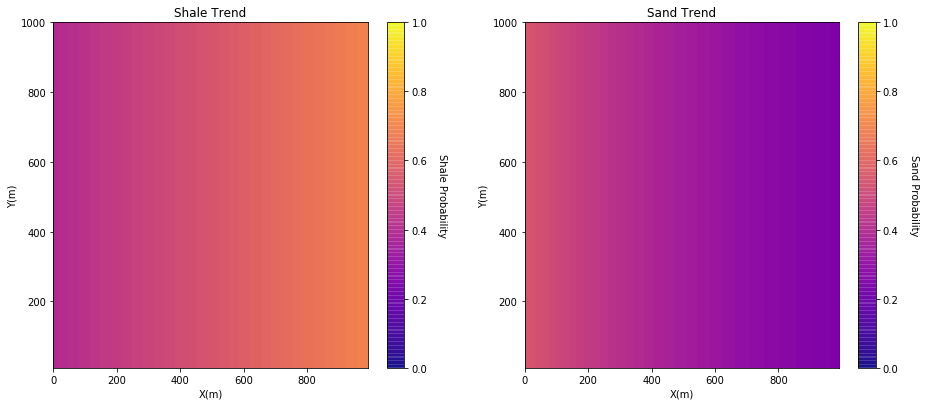

In [429]:
trend = np.zeros((nx,ny,ncut)); trend[:,:,0] = 0.8; trend[:,:,1] = 0.2
for iy in range(0,ny):
    for ix in range(0,nx):
        trend[iy,ix,0] = 0.4 + (ix/nx) * 0.3
trend = correct_trend(trend)

plt.subplot(121)
GSLIB.pixelplt_st(trend[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Shale Trend','X(m)','Y(m)','Shale Probability',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(trend[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Sand Trend','X(m)','Y(m)','Sand Probability',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Now we are ready to perform indicator kriging.

In [430]:
ikmap = ik2d(df,'X','Y','Facies',ivtype,0,2,thresh,gcdf,trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,
         ndmin,ndmax,radius,ktype,vario=varios)

Data for IK3D: Variable column Facies
  Number   = 480
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 1000
   currently on estimate 2000
   currently on estimate 3000
   currently on estimate 4000
   currently on estimate 5000
   currently on estimate 6000
   currently on estimate 7000
   currently on estimate 8000
   currently on estimate 9000


Let's see what we just calculated. Recall with indicato-based methods, we do not get a single estimate nor realization, but the entire local CDF.  In this case we get the probabability of shale and sand at all locations.

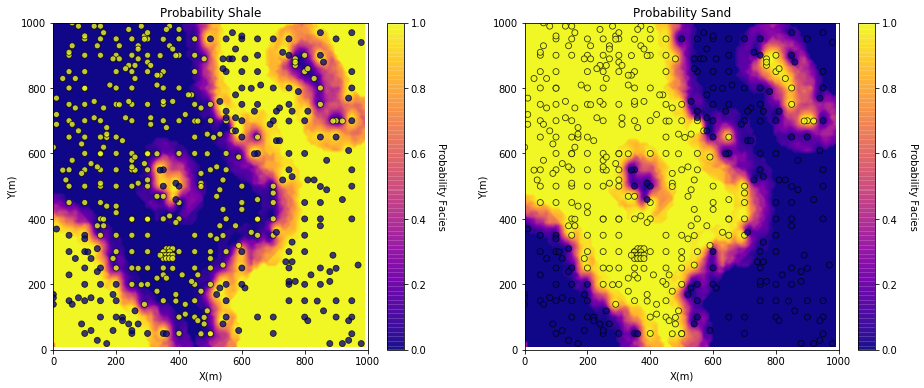

In [431]:
plt.subplot(221)
GSLIB.locpix_st(ikmap[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Shale','X(m)','Y(m)','Probability Facies',cmap)

plt.subplot(222)
GSLIB.locpix_st(ikmap[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Sand','X(m)','Y(m)','Probability Facies',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()


I hope you find this code and demonstration useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

**Michael Pyrcz**, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
On Twitter I'm the **GeostatsGuy** and on YouTube my lectures are on the channel, **GeostatsGuy Lectures**.